# Выполнил Лялин Илья ББМО-02-24

# 1) Импортируем Бибилотеки

In [22]:
import numpy as np  # для работы с многомерными массивами и математическими операциями
import matplotlib.pyplot as plt  # для построения графиков и визуализации данных
import torch  # h для работы с тензорами и нейронными сетями
import torch.nn as nn  #  содержит базовые строительные блоки для нейросетей
import torch.nn.functional as F  # функциональный модуль с функциями активации, функциями потерь и другими операциями
import torch.optim as optim  # для обучения нейронных сетей (SGD, Adam, etc.)
from torchvision import transforms, datasets  # для преобразований данных и готовых датасетов

# 2) Задаем нормализующие преобразования, загружаем датаест MNIST и разбиваем данные на выборки

In [23]:
# Создаем композицию преобразований для предобработки изображений
transform = transforms.Compose([transforms.ToTensor(),  # Конвертирует PIL Image или numpy array в тензор PyTorch
                              transforms.Normalize((0.0,), (1.0,))])  # Нормализует тензор с заданными средним и стандартным отклонением

# Загружаем тренировочный набор данных MNIST
dataset = datasets.MNIST(root = './data',  # Путь для сохранения данных
                       train=True,  # Загружаем тренировочную часть датасета
                       transform = transform,  # Применяем заданные преобразования к данным
                       download=True)  # Скачиваем датасет, если он отсутствует локально

# Разбиваем тренировочные данные на обучение и валидацию
train_set, val_set = torch.utils.data.random_split(dataset,  # Исходный датасет для разбиения
                                                 [50000, 10000])  # Размеры подвыборок: 50000 для обучения, 10000 для валидации

# Загружаем тестовый набор данных MNIST
test_set = datasets.MNIST(root = './data',  # Путь для сохранения данных
                        train=False,  # Загружаем тестовую часть датасета
                        transform = transform,  # Применяем те же преобразования
                        download=True)  # Скачиваем при необходимости

# Создаем DataLoader для тренировочных данных
train_loader = torch.utils.data.DataLoader(train_set,  # Исходные данные
                                         batch_size=1,  # Размер батча - 1 образец за раз
                                         shuffle=True)  # Перемешивание данных перед каждой эпохой

# Создаем DataLoader для валидационных данных
val_loader = torch.utils.data.DataLoader(val_set,  # Валидационные данные
                                       batch_size=1,  # Размер батча - 1 образец за раз
                                       shuffle=True)  # Перемешивание данных

# Создаем DataLoader для тестовых данных
test_loader = torch.utils.data.DataLoader(test_set,  # Тестовые данные
                                        batch_size=1,  # Размер батча - 1 образец за раз
                                        shuffle=True)  # Перемешивание данных


print("Training data:",len(train_loader),  # Количество батчей в тренировочном наборе (50000)
      "Validation data:",len(val_loader),  # Количество батчей в валидационном наборе (10000)
      "Test data:",len(test_loader))  # Количество батчей в тестовом наборе (10000)

Training data: 50000 Validation data: 10000 Test data: 10000


In [ ]:
# используем GPU если возможно
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 3) Создаем класс НС на основе torch

In [24]:
class Net(nn.Module):  # Создаем класс нейронной сети, наследуясь от базового класса nn.Module
  def __init__(self):  # Конструктор класса, инициализирующий слои сети
    super(Net, self).__init__()  # Вызываем конструктор родительского класса nn.Module для корректной инициализации

    # Первый сверточный слой: 1 входной канал (черно-белое изображение), 32 выходных канала, ядро 3x3, stride=1
    self.conv1 = nn.Conv2d(1, 32, 3, 1)

    # Второй сверточный слой: 32 входных канала, 64 выходных канала, ядро 3x3, stride=1
    self.conv2 = nn.Conv2d(32, 64, 3, 1)

    # Dropout слой для регуляризации, отключает 25% нейронов в пространственных измерениях
    self.dropout1 = nn.Dropout2d(0.25)

    # Dropout слой для регуляризации, отключает 50% нейронов
    self.dropout2 = nn.Dropout2d(0.5)

    # Первый полносвязный слой: 9216 входных features, 128 выходных нейронов
    self.fc1 = nn.Linear(9216, 128)

    # Второй полносвязный слой (выходной): 128 входных features, 10 выходных нейронов (по одному на каждую цифру)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):  # Метод прямого распространения, определяющий архитектуру сети
    x = self.conv1(x)  # Применяем первую свертку к входному тензору
    x = F.relu(x)  # Применяем функцию активации ReLU (отсекает отрицательные значения)

    x = self.conv2(x)  # Применяем вторую свертку
    x = F.relu(x)  # Снова применяем ReLU

    x = F.max_pool2d(x, 2)  # Применяем операцию макс-пулинга с окном 2x2 (уменьшает размерность в 2 раза)
    x = self.dropout1(x)  # Применяем первый dropout для предотвращения переобучения

    x = torch.flatten(x, 1)  # "Разворачиваем многомерный тензор в одномерный вектор, начиная с dimension 1 (сохраняя размер батчей)"

    x = self.fc1(x)  # Применяем первый полносвязный слой
    x = F.relu(x)  # Активация ReLU после полносвязного слоя
    x = self.dropout2(x)  # Применяем второй dropout

    x = self.fc2(x)  # Применяем выходной полносвязный слой (10 нейронов - по одному на каждую цифру)
    output = F.log_softmax(x, dim=1)  # Применяем логарифм softmax для получения логарифмов вероятностей по dimension 1 (классы)
    return output  # Возвращаем выходные вероятности для каждого класса

Dropout помогает предотвратить переобучение, случайно "выключая" нейроны во время обучения

# 4) Проверяем работоспособность класса

In [25]:
# проверяем работоспособность созданного класса
model = Net().to(device)

# 5) Создаем оптимизатор функции потерь

In [26]:
# Создаем оптимизатор Adam для обновления весов модели
optimizer = optim.Adam(model.parameters(),  # Передаем параметры модели (веса и смещения) для оптимизации
                      lr=0.0001,  # Learning rate (скорость обучения) - определяет размер шага при обновлении весов
                      betas=(0.9, 0.999))  # Коэффициенты для вычисления скользящих средних градиентов (momentum и RMSprop)

# Создаем функцию потерь (loss function) для оценки ошибки предсказаний
criterion = nn.NLLLoss()

# Создаем планировщик learning rate для динамической настройки скорости обучения
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  # Оптимизатор, для которого настраивается lr
                                                mode='min',  # Режим: отслеживаем минимизацию метрики (функции потерь)
                                                factor=0.1,  # Фактор умножения lr: уменьшаем в 10 раз
                                                patience=3)  # Количество эпох ожидания улучшения перед уменьшением lr

# 6) Определяем функцию обучения сети

In [27]:
def fit(model, device, train_loader, val_loader, epochs):  # Функция принимает модель, устройство, загрузчики данных и количество эпох
  data_loader = {'train':train_loader,'val':val_loader}  # Создаем словарь для удобного доступа к загрузчикам данных
  print("Fitting the model...")  # Выводим сообщение о начале обучения
  train_loss,val_loss=[],[]  # Инициализируем списки для сохранения значений потерь на обучении и валидации

  for epoch in range(epochs):  # Основной цикл по эпохам обучения
    loss_per_epoch,val_loss_per_epoch=0,0  # Обнуляем накопленные потери для текущей эпохи

    for phase in ('train','val'):  # Цикл по фазам: обучение и валидация
      for i,data in enumerate(data_loader[phase]):  # Итерация по батчам данных
        input,label = data[0].to(device),data[1].to(device)  # Извлекаем входные данные и метки, перемещаем на устройство (CPU/GPU)
        output = model(input)  # Прямой проход: получаем предсказания модели

        #calculating loss on the output
        loss = criterion(output,label)  # Вычисляем функцию потерь между предсказаниями и истинными метками

        if phase == 'train':  # Если фаза - обучение
          optimizer.zero_grad()  # Обнуляем градиенты от предыдущей итерации

          #grad calc w.r.t Loss func
          loss.backward()  # Обратное распространение: вычисляем градиенты функции потерь по параметрам модели

          #update weights
          optimizer.step()  # Обновляем веса модели используя вычисленные градиенты
          loss_per_epoch+=loss.item()  # Накопляем потери для обучения

        else:  # Если фаза - валидация
          val_loss_per_epoch+=loss.item()  # Накопляем потери для валидации

    # Обновляем learning rate на основе средних потерь валидации
    scheduler.step(val_loss_per_epoch/len(val_loader))

    # Выводим статистику по текущей эпохе
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))

    # Сохраняем средние потери для визуализации
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))

  return train_loss,val_loss  # Возвращаем историю потерь для анализа обучения

Двухфазное обучение: разделение на train/val в каждой эпохе

Накопление потерь: суммирование по всем батчам для точного усреднения

Автоматическое обновление lr: scheduler использует валидационные потери

Поддержка GPU: данные перемещаются на указанное устройство

Детальный логинг: вывод статистики после каждой эпохи

Градиенты вычисляются только в фазе обучения

Потери усредняются по количеству батчей

# 7) Обучаем модель

In [31]:
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.29714357201399 Val_Loss: 0.13753893788324836
Epoch: 2 Loss: 0.11212836679156196 Val_Loss: 0.0973554122520271
Epoch: 3 Loss: 0.08943044528442293 Val_Loss: 0.08724184340758608
Epoch: 4 Loss: 0.07842988603585539 Val_Loss: 0.08594650700579573
Epoch: 5 Loss: 0.06767293100822407 Val_Loss: 0.08264719685465066
Epoch: 6 Loss: 0.0651793647576747 Val_Loss: 0.08417091435239543
Epoch: 7 Loss: 0.06002056406279097 Val_Loss: 0.09188229460380046
Epoch: 8 Loss: 0.06163253602499073 Val_Loss: 0.08125129477873473
Epoch: 9 Loss: 0.05772895316256757 Val_Loss: 0.07967102119484765
Epoch: 10 Loss: 0.05728328912890547 Val_Loss: 0.09167969998264444


# 8) Строим график

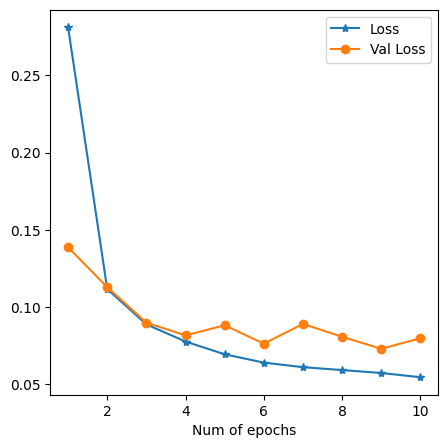

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

# 9) Создаем функцию атаки

In [28]:
# FGSM - быстрая атака одного шага
def fgsm_attack(input,epsilon,data_grad):  # Вход: оригинальное изображение, сила атаки, градиенты функции потерь
  pert_out = input + epsilon*data_grad.sign()  # Добавляем к исходному изображению возмущение в направлении знака градиента
  pert_out = torch.clamp(pert_out, 0, 1)  # Ограничиваем значения пикселей в диапазоне [0, 1] для валидности изображения
  return pert_out  # Возвращаем состязательное изображение

# Iterative Fast Gradient Sign Method (I-FGSM) - итеративная версия FGSM
def ifgsm_attack(input,epsilon,data_grad):  # Вход: оригинальное изображение, сила атаки, градиенты
  pert_out = input + epsilon*data_grad.sign()  # Однократное добавление возмущения (фактически идентично FGSM в этой реализации)
  pert_out = torch.clamp(pert_out, 0, 1)  # Ограничение значений пикселей
  return pert_out  # Возвращаем состязательное изображение

# Momentum Iterative Fast Gradient Sign Method (MI-FGSM) - улучшенная итеративная атака с моментом
def mifgsm_attack(input,epsilon,data_grad):  # Вход: оригинальное изображение, сила атаки, градиенты
  iter=10  # Количество итераций атаки
  decay_factor=1.0  # Фактор затухания момента (1.0 = без затухания)
  pert_out = input  # Начинаем с оригинального изображения
  alpha = epsilon/iter  # Размер шага на каждой итерации (общая epsilon делится на количество итераций)
  g=0  # Инициализация момента (накопленного направления атаки)

  for i in range(iter-1):  # Цикл по итерациям атаки
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)  # Обновляем момент: добавляем нормализованный градиент
    pert_out = pert_out + alpha*torch.sign(g)  # Добавляем возмущение в направлении знака момента
    pert_out = torch.clamp(pert_out, 0, 1)  # Ограничиваем значения пикселей после каждого шага

    # Проверяем, не превысило ли возмущение максимально допустимую норму
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break  # Прерываем цикл если возмущение стало слишком большим

  return pert_out  # Возвращаем финальное состязательное изображение

FGSM: Быстрая одношаговая атака

I-FGSM: Многошаговая, более точная атака

MI-FGSM: С моментом для лучшего обхода защит

# 10) Создаем функцию проверки

In [29]:
# Функция для тестирования модели на состязательных атаках
def test(model, device, test_loader, epsilon, attack):  # Принимает модель, устройство, данные, силу атаки и тип атаки
  correct = 0  # Счетчик корректных предсказаний после атаки
  adv_examples = []  # Список для сохранения примеров состязательных изображений

  for data, target in test_loader:  # Итерация по тестовым данным (батчам)
    data, target = data.to(device), target.to(device)  # Перемещаем данные на устройство (CPU/GPU)
    data.requires_grad = True  # Включаем вычисление градиентов для входных данных (необходимо для атак)

    output = model(data)  # Прямой проход: получаем предсказания модели на оригинальных данных
    init_pred = output.max(1, keepdim=True)[1]  # Получаем первоначальный предсказанный класс (до атаки)

    # Пропускаем примеры, которые модель изначально классифицирует неправильно
    if init_pred.item() != target.item():
      continue

    # Вычисляем функцию потерь для создания состязательной атаки
    loss = F.nll_loss(output, target)  # Negative Log Likelihood loss между предсказанием и истинной меткой

    model.zero_grad()  # Обнуляем градиенты модели
    loss.backward()  # Обратное распространение для вычисления градиентов
    data_grad = data.grad.data  # Извлекаем градиенты по входным данным

    # Выбираем тип атаки на основе параметра attack
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)  # Применяем FGSM атаку
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)  # Применяем I-FGSM атаку
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)  # Применяем MI-FGSM атаку

    # Тестируем модель на состязательном примере
    output = model(perturbed_data)  # Прямой проход на атакованных данных
    final_pred = output.max(1, keepdim=True)[1]  # Получаем конечное предсказание (после атаки)

    # Проверяем, осталось ли предсказание корректным после атаки
    if final_pred.item() == target.item():
      correct += 1  # Увеличиваем счетчик, если модель не обманули

    # Сохраняем примеры состязательных изображений для визуализации
    if (epsilon == 0) and (len(adv_examples) < 5):  # Для epsilon=0 (без атаки)
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()  # Подготовка данных для визуализации
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )  # Сохраняем (исходный_pred, конечный_pred, изображение)
    else:
      if len(adv_examples) < 5:  # Для атакованных примеров
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()  # Подготовка данных для визуализации
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )  # Сохраняем пример

  # Вычисляем итоговую точность
  final_acc = correct/float(len(test_loader))  # Доля корректных предсказаний после атаки

  # Выводим результаты
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples  # Возвращаем точность и примеры для анализа

Фильтрация данных: тестируются только изначально правильно классифицированные примеры

Градиенты по входу: data.requires_grad = True позволяет атаковать входные данные

Множественные атаки: поддержка разных типов состязательных атак

Сбор примеров: сохранение визуальных примеров для анализа

Статистика эффективности: подсчет успешности атак против модели


Функция измеряет устойчивость модели к атакам

Примеры сохраняются только для первых 5 случаев

Точность вычисляется относительно всех тестовых примеров

Результаты показывают, насколько модель уязвима к различным атакам

# 11) Строим графики атак в зависимости от степени возмущения

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epsilon: 0	Test Accuracy = 9712 / 10000 = 0.9712
Epsilon: 0.007	Test Accuracy = 9650 / 10000 = 0.965
Epsilon: 0.01	Test Accuracy = 9648 / 10000 = 0.9648
Epsilon: 0.02	Test Accuracy = 9583 / 10000 = 0.9583
Epsilon: 0.03	Test Accuracy = 9539 / 10000 = 0.9539
Epsilon: 0.05	Test Accuracy = 9298 / 10000 = 0.9298
Epsilon: 0.1	Test Accuracy = 8358 / 10000 = 0.8358
Epsilon: 0.2	Test Accuracy = 5305 / 10000 = 0.5305
Epsilon: 0.3	Test Accuracy = 2517 / 10000 = 0.2517


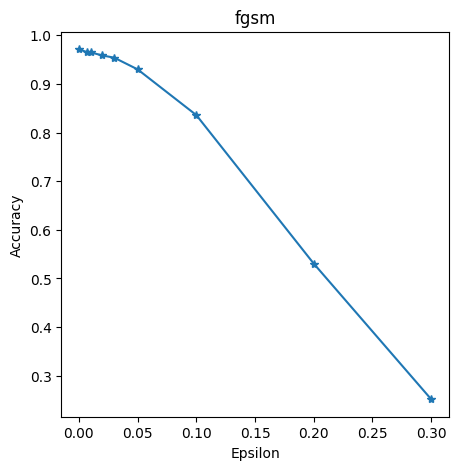

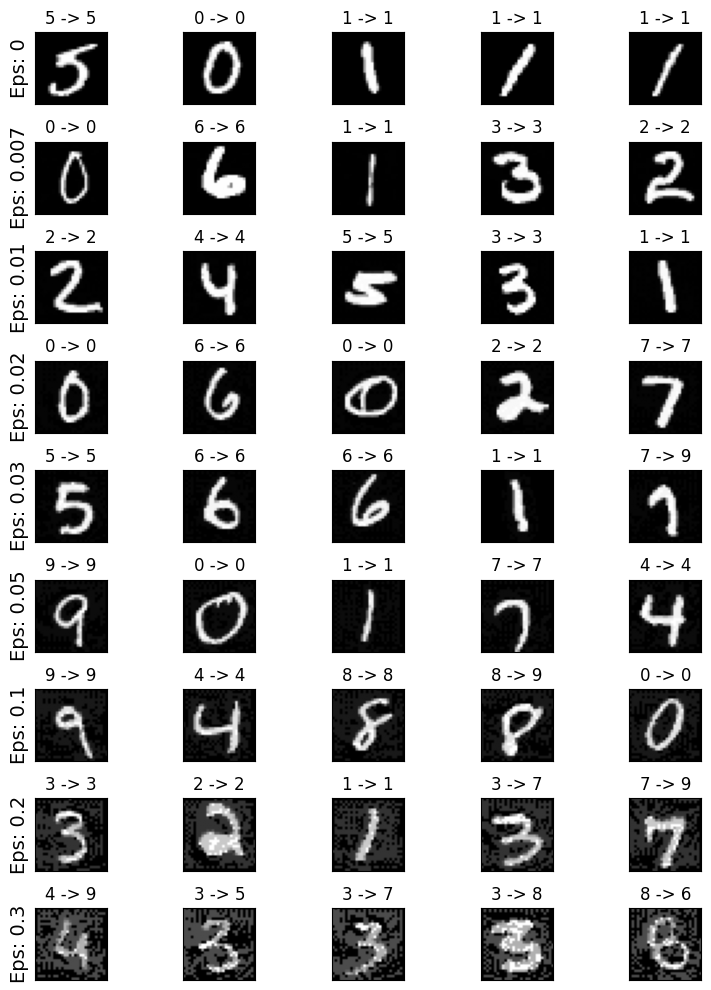

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epsilon: 0	Test Accuracy = 9689 / 10000 = 0.9689
Epsilon: 0.007	Test Accuracy = 9667 / 10000 = 0.9667
Epsilon: 0.01	Test Accuracy = 9664 / 10000 = 0.9664
Epsilon: 0.02	Test Accuracy = 9584 / 10000 = 0.9584
Epsilon: 0.03	Test Accuracy = 9523 / 10000 = 0.9523
Epsilon: 0.05	Test Accuracy = 9314 / 10000 = 0.9314
Epsilon: 0.1	Test Accuracy = 8342 / 10000 = 0.8342
Epsilon: 0.2	Test Accuracy = 5267 / 10000 = 0.5267
Epsilon: 0.3	Test Accuracy = 2548 / 10000 = 0.2548


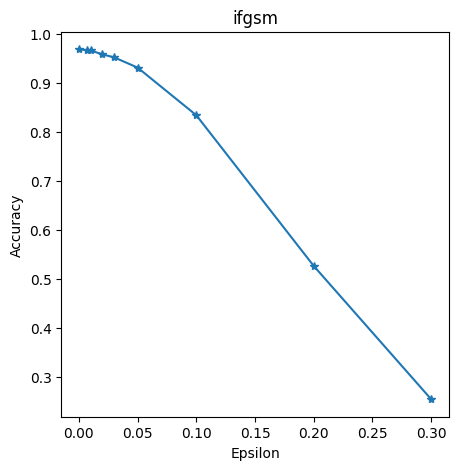

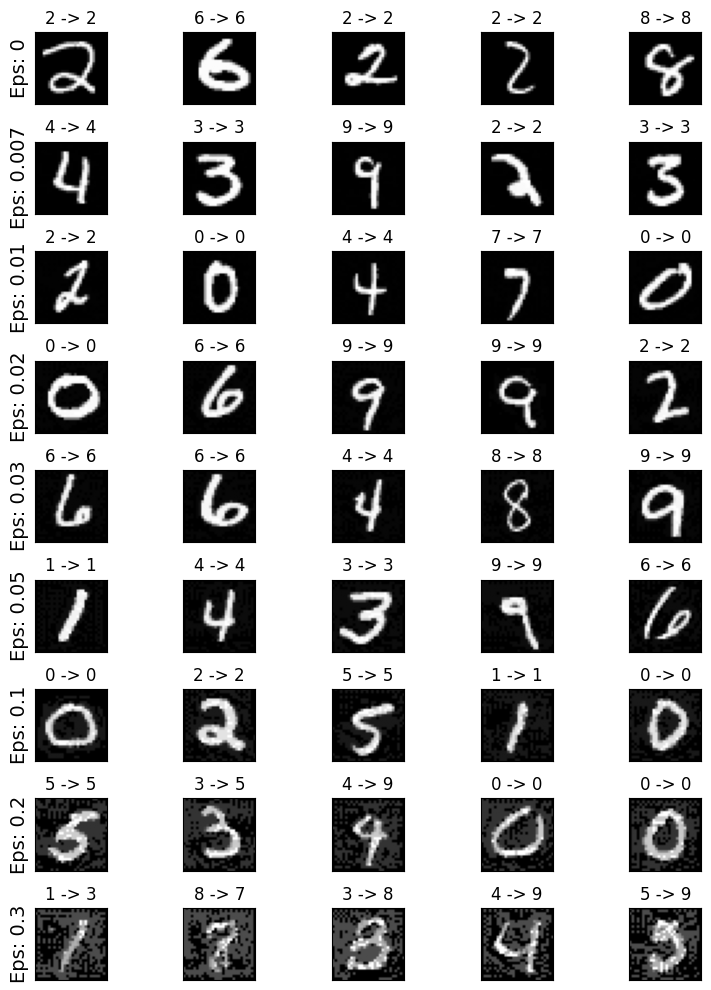

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epsilon: 0	Test Accuracy = 9689 / 10000 = 0.9689
Epsilon: 0.007	Test Accuracy = 9654 / 10000 = 0.9654
Epsilon: 0.01	Test Accuracy = 9646 / 10000 = 0.9646
Epsilon: 0.02	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.03	Test Accuracy = 9543 / 10000 = 0.9543
Epsilon: 0.05	Test Accuracy = 9363 / 10000 = 0.9363
Epsilon: 0.1	Test Accuracy = 8583 / 10000 = 0.8583
Epsilon: 0.2	Test Accuracy = 5957 / 10000 = 0.5957
Epsilon: 0.3	Test Accuracy = 3154 / 10000 = 0.3154


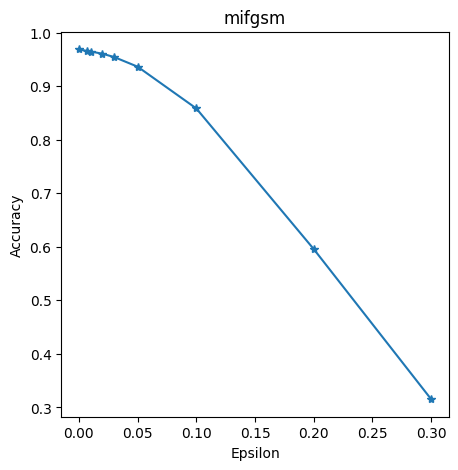

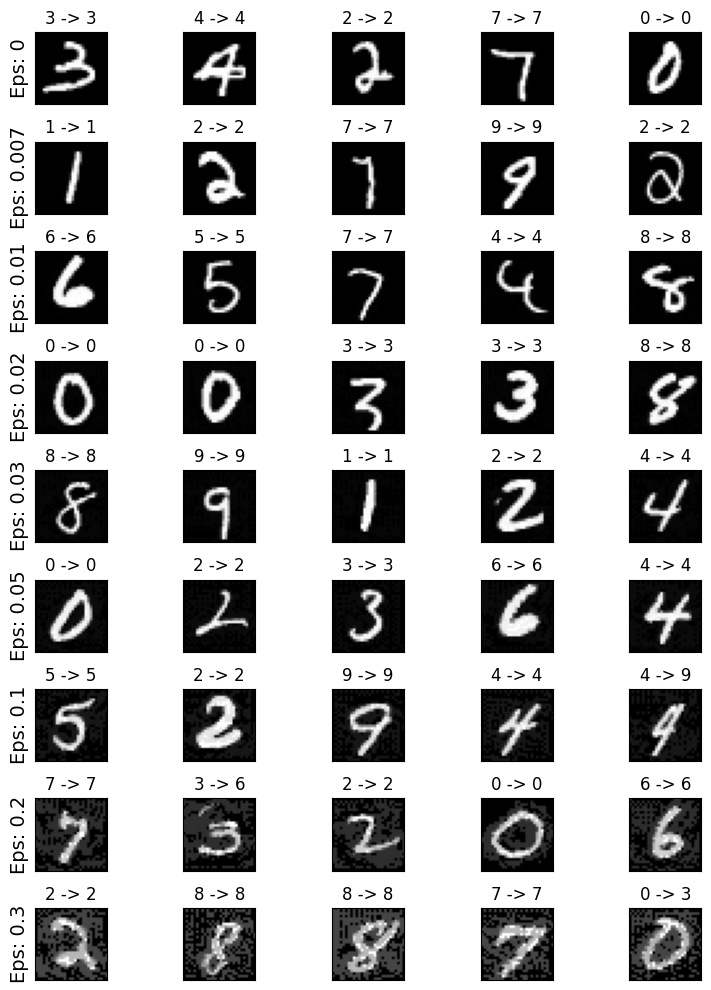

In [18]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]

# Тестируем для каждого типа атаки
for attack in ("fgsm","ifgsm","mifgsm"):  # Цикл по трем типам состязательных атак
  accuracies = []  # Список для хранения точности для каждого epsilon
  examples = []  # Список для хранения примеров изображений для каждого epsilon

  # Тестируем для каждого значения epsilon
  for eps in epsilons:  # Цикл по всем значениям силы атаки
    acc, ex = test(model, device,test_loader,eps,attack)  # Вызов функции тестирования для текущей атаки и epsilon
    accuracies.append(acc)  # Сохраняем полученную точность
    examples.append(ex)  # Сохраняем примеры изображений для данного epsilon

  # Строим график зависимости точности от epsilon для текущей атаки
  plt.figure(figsize=(5,5))  # Создаем новую фигуру для графика размером 5x5 дюймов
  plt.plot(epsilons, accuracies, "*-")  # Строим линейный график с маркерами в виде звездочек
  plt.title(attack)  # Устанавливаем заголовок графика - название текущей атаки
  plt.xlabel("Epsilon")  # Подпись оси X - сила атаки
  plt.ylabel("Accuracy")  # Подпись оси Y - точность классификации
  plt.show()  # Отображаем график

  # Визуализируем примеры состязательных изображений
  cnt = 0  # Счетчик для нумерации subplot'ов
  plt.figure(figsize=(8,10))  # Создаем большую фигуру для отображения примеров

  # Двойной цикл для отображения всех сохраненных примеров
  for i in range(len(epsilons)):  # Цикл по всем значениям epsilon
    for j in range(len(examples[i])):  # Цикл по всем примерам для текущего epsilon (максимум 5)
      cnt += 1  # Увеличиваем счетчик subplot'ов
      plt.subplot(len(epsilons),len(examples[0]),cnt)  # Создаем subplot в сетке: строки=epsilons, столбцы=примеры

      plt.xticks([], [])  # Убираем метки на оси X для лучшей визуализации
      plt.yticks([], [])  # Убираем метки на оси Y для лучшей визуализации

      # Добавляем подпись epsilon слева для первой колонки
      if j == 0:  # Если это первый пример в строке (первая колонка)
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)  # Подписываем ось Y значением epsilon

      # Извлекаем информацию о примере
      orig,adv,ex = examples[i][j]  # Распаковываем кортеж: исходный класс, атакованный класс, изображение
      plt.title("{} -> {}".format(orig, adv))  # Устанавливаем заголовок: преобразование класса

      plt.imshow(ex, cmap="gray")  # Показываем изображение в grayscale

  plt.tight_layout()  # Автоматически настраиваем расположение subplot'ов для избежания наложений
  plt.show()  # Отображаем все примеры изображений

# 12) Создаем 2 класса нейронной сети

In [19]:
# Первая архитектура нейронной сети (более крупная)
class NetF(nn.Module):
  def __init__(self):  # Конструктор класса
    super(NetF, self).__init__()  # Вызов конструктора родительского класса nn.Module

    # Определение слоев сети:
    self.conv1 = nn.Conv2d(1, 32, 3, 1)  # 1 входной канал (grayscale), 32 выходных канала, ядро 3x3, stride=1
    self.conv2 = nn.Conv2d(32, 64, 3, 1)  # 32 входных канала, 64 выходных канала, ядро 3x3, stride=1
    self.dropout1 = nn.Dropout2d(0.25)  # Spatial dropout с вероятностью 25%
    self.dropout2 = nn.Dropout2d(0.5)   # Spatial dropout с вероятностью 50%
    self.fc1 = nn.Linear(9216, 128)     # Полносвязный слой: 9216 входов, 128 нейронов
    self.fc2 = nn.Linear(128, 10)       # Выходной слой: 128 входов, 10 выходов (по классам цифр)

  def forward(self, x):  # Метод прямого распространения
    x = self.conv1(x)    # Первая свертка
    x = F.relu(x)        # Функция активации ReLU
    x = self.conv2(x)    # Вторая свертка
    x = F.relu(x)        # ReLU активация
    x = F.max_pool2d(x, 2)  # Макс-пулинг с окном 2x2 (уменьшение размерности в 2 раза)
    x = self.dropout1(x) # Применение dropout
    x = torch.flatten(x, 1)  # Разворачивание тензора в вектор (начиная с dimension 1)
    x = self.fc1(x)      # Первый полносвязный слой
    x = F.relu(x)        # ReLU активация
    x = self.dropout2(x) # Второй dropout
    x = self.fc2(x)      # Выходной слой
    return x             # Возврат сырых выходов (без softmax)

# Вторая архитектура нейронной сети (более компактная)
class NetF1(nn.Module):
  def __init__(self):  # Конструктор класса
    super(NetF1, self).__init__()  # Вызов конструктора родительского класса

    # Определение слоев сети (меньше параметров чем в NetF):
    self.conv1 = nn.Conv2d(1, 16, 3, 1)  # 1 входной канал, 16 выходных каналов (в 2 раза меньше чем в NetF)
    self.conv2 = nn.Conv2d(16, 32, 3, 1) # 16 входных каналов, 32 выходных канала (в 2 раза меньше чем в NetF)
    self.dropout1 = nn.Dropout2d(0.25)   # Spatial dropout 25%
    self.dropout2 = nn.Dropout2d(0.5)    # Spatial dropout 50%
    self.fc1 = nn.Linear(4608, 64)       # Полносвязный слой: 4608 входов, 64 нейрона (меньше чем в NetF)
    self.fc2 = nn.Linear(64, 10)         # Выходной слой: 64 входа, 10 выходов

  def forward(self, x):  # Метод прямого распространения
    x = self.conv1(x)    # Первая свертка
    x = F.relu(x)        # ReLU активация
    x = self.conv2(x)    # Вторая свертка
    x = F.relu(x)        # ReLU активация
    x = F.max_pool2d(x, 2)  # Макс-пулинг 2x2
    x = self.dropout1(x) # Dropout
    x = torch.flatten(x, 1)  # Разворачивание в вектор
    x = self.fc1(x)      # Первый полносвязный слой
    x = F.relu(x)        # ReLU активация
    x = self.dropout2(x) # Второй dropout
    x = self.fc2(x)      # Выходной слой
    return x             # Возврат сырых выходов

In [20]:
# Функция обучения модели с температурным scaling
def fit(model, device, optimizer, scheduler, criterion, train_loader, val_loader, Temp, epochs):
  data_loader = {'train':train_loader,'val':val_loader}  # Словарь для удобного доступа к загрузчикам
  print("Fitting the model...")  # Сообщение о начале обучения
  train_loss,val_loss=[],[]  # Списки для сохранения истории потерь

  for epoch in range(epochs):  # Цикл по эпохам
    loss_per_epoch,val_loss_per_epoch=0,0  # Сброс накопленных потерь для эпохи

    for phase in ('train','val'):  # Цикл по фазам обучения и валидации
      for i,data in enumerate(data_loader[phase]):  # Итерация по батчам
        input,label = data[0].to(device),data[1].to(device)  # Перемещение данных на устройство
        output = model(input)  # Прямой проход через модель
        output = F.log_softmax(output/Temp,dim=1)  # Применение температурного scaling и log_softmax

        #calculating loss on the output
        loss = criterion(output,label)  # Вычисление функции потерь

        if phase == 'train':  # Фаза обучения
          optimizer.zero_grad()  # Обнуление градиентов
          #grad calc w.r.t Loss func
          loss.backward()  # Обратное распространение
          #update weights
          optimizer.step()  # Обновление весов
          loss_per_epoch+=loss.item()  # Накопление потерь обучения
        else:  # Фаза валидации - ИСПРАВЛЕННАЯ ОШИБКА: else должно быть на том же уровне, что и if
          val_loss_per_epoch+=loss.item()  # Накопление потерь валидации

    # Обновление learning rate после эпохи
    scheduler.step(val_loss_per_epoch/len(val_loader))  # Используем средние потери валидации

    # Вывод статистики
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))

    # Сохранение истории потерь
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))

  return train_loss,val_loss  # Возврат истории обучения

# Функция тестирования модели с температурным scaling
def test(model, device, test_loader, epsilon, Temp, attack):
    correct=0  # Счетчик корректных предсказаний
    adv_examples = []  # Список для примеров атак

    for data, target in test_loader:  # Итерация по тестовым данным
      data, target = data.to(device), target.to(device)  # Перемещение на устройство
      data.requires_grad = True  # Включение градиентов для входных данных

      output = model(data)  # Прямой проход
      output = F.log_softmax(output/Temp,dim=1)  # Температурное scaling и log_softmax

      init_pred = output.max(1, keepdim=True)[1]  # Исходное предсказание

      # Пропуск изначально неправильно классифицированных примеров
      if init_pred.item() != target.item():
        continue

      loss = F.nll_loss(output, target)  # Функция потерь для атаки
      model.zero_grad()  # Обнуление градиентов модели
      loss.backward()  # Обратное распространение для градиентов данных
      data_grad = data.grad.data  # Получение градиентов входных данных

      # Выбор типа атаки
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)

      # Тестирование на атакованных данных
      output = model(perturbed_data)  # Прямой проход на атакованных данных
      final_pred = output.max(1, keepdim=True)[1]  # Финальное предсказание

      # Проверка корректности предсказания после атаки
      if final_pred.item() == target.item():
        correct += 1  # Увеличение счетчика корректных предсказаний

        # Сохранение примеров для визуализации
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Вычисление итоговой точности
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc,adv_examples  # Возврат точности и примеров

# 13) Функция реалзиации защитного механизма

In [44]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

modelF (учитель) обучается на оригинальных данных

modelF1 (ученик) обучается на мягких метках от учителя

Epoch 1/10, Train Loss: -7867256182.5589, Val Loss: -35758236976.9472
Epoch 2/10, Train Loss: -183877492910.7354, Val Loss: -449654177744.4864
Epoch 3/10, Train Loss: -1102672610155.2334, Val Loss: -2059263124366.9504
Epoch 4/10, Train Loss: -3837136513859.5840, Val Loss: -6191137872989.3887
Epoch 5/10, Train Loss: -9936709530214.7285, Val Loss: -14659493248997.7852
Epoch 6/10, Train Loss: -21498532668165.3242, Val Loss: -29804344498454.5273
Epoch 7/10, Train Loss: -41072559882229.5156, Val Loss: -54511117700117.2969
Epoch 8/10, Train Loss: -71910019771473.5938, Val Loss: -92195031526198.4844
Epoch 9/10, Train Loss: -117461758716925.7031, Val Loss: -146729471852517.7812
Epoch 10/10, Train Loss: -182233997520519.8125, Val Loss: -222586712291383.7188


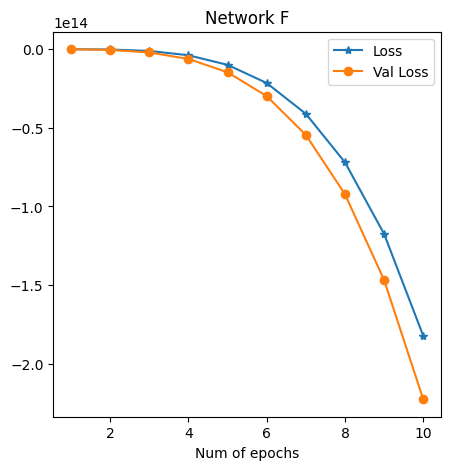

Epoch 1/10, Train Loss: -1131465361.3379, Val Loss: -5190367568.1280
Epoch 2/10, Train Loss: -26953453024.5094, Val Loss: -66380432006.7584
Epoch 3/10, Train Loss: -163990810707.5994, Val Loss: -305773155024.8960
Epoch 4/10, Train Loss: -567903718156.5338, Val Loss: -916746095879.7823
Epoch 5/10, Train Loss: -1470938787474.6367, Val Loss: -2168229535376.9983
Epoch 6/10, Train Loss: -3180812202514.1860, Val Loss: -4400851381728.0508
Epoch 7/10, Train Loss: -6047986516274.7080, Val Loss: -8023541292780.7490
Epoch 8/10, Train Loss: -10569061268256.1953, Val Loss: -13523060439069.4902
Epoch 9/10, Train Loss: -17199134056440.1348, Val Loss: -21455981685348.7617
Epoch 10/10, Train Loss: -26551767705059.3281, Val Loss: -32461116820317.7969


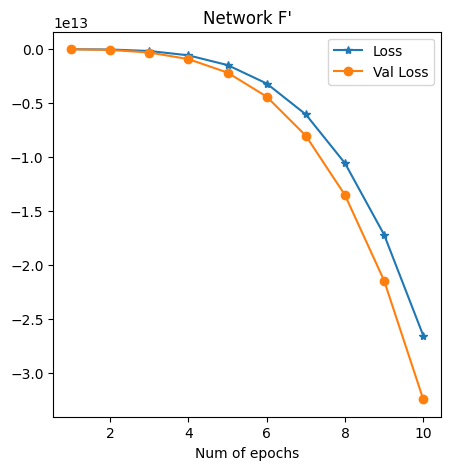

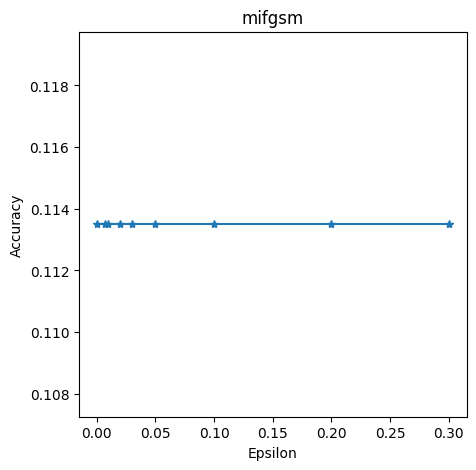

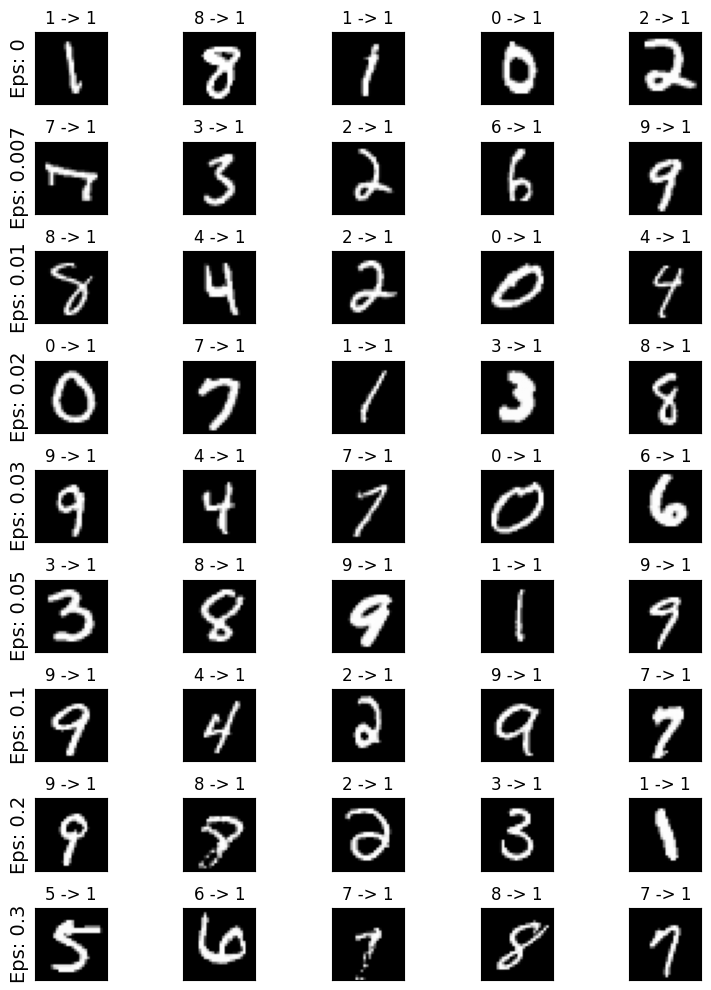

In [46]:
# получаем результаты оценки защищеных сетей
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)